In [1]:
import os
import sys
import tarfile
import collections
import torch
import torch.utils.data as data
from torchvision.datasets.utils import download_url, check_integrity
from torchvision import datasets
import torchvision as tv
import numpy as np
import matplotlib.pyplot as plt
import argparse
from models import *
from torch.utils.data import DataLoader
from utils.logger import *
from utils.utils import *
from utils.datasets import *
from utils.parse_config import *
from terminaltables import AsciiTable
import datetime
from test import evaluate
from torch.autograd import Variable
from matplotlib.ticker import NullLocator
%matplotlib notebook


In [4]:
%matplotlib notebook



In [5]:
save_loss_path = 'loss_list.npy'
save_map_path = 'map_list.npy'
save_precision_path = 'precision_list.npy'

x=np.load(save_loss_path)

y=np.load(save_map_path)

z=np.load(save_precision_path)

# x = x[0:17]
# y = y[0:17]
# z = z[0:17]
print(x)
print(y)
print(z)

print(len(x))

print(max(y))
# np.save(save_loss_path, x)

# np.save(save_map_path, y)

# np.save(save_precision_path, z)

#18数据爆炸
#21改变了bbox计算方式

[7.78233566e+01 2.48466759e+01 1.12448921e+01 8.89546204e+00
 6.30536270e+00 3.31850243e+00 3.44516039e+00 2.56457949e+00
 1.92526698e+00 2.93959999e+00 1.21242213e+00 1.44278955e+00
 1.46114504e+00 1.31096911e+00 1.13493812e+00 1.06520700e+00
 9.75635350e-01 1.08324540e+00 9.67097282e-01 1.23946238e+00
 7.30531514e-01 6.94690466e-01 8.12710822e-01 8.90422225e-01
 7.50972986e-01 6.53702736e-01 4.57458436e-01 5.59940696e-01
 8.05926323e-01 9.77636039e-01 1.22760880e+00 5.19323826e-01
 6.24897599e-01 5.15572071e-01 5.34504533e-01 4.74685609e-01
 5.35446346e-01 9.83404279e-01 5.18904030e-01 4.15502548e-01
 7.06089616e-01 7.01815844e-01 3.18342924e-01 5.88742495e-01
 4.12982792e-01 4.81637985e-01 3.40006202e-01 3.32732201e-01
 4.53536928e-01 2.15952843e-01 5.52287936e-01 6.27857745e-01
 8.81560385e-01 4.17819649e-01 2.52633393e-01 2.05586344e-01
 2.88033932e-01 6.64576650e-01 1.00321686e+00 2.51256704e-01
 6.14655435e-01 5.30752778e-01 2.66187370e-01 5.49847424e-01
 3.84434402e-01 2.053776

<IPython.core.display.Javascript object>


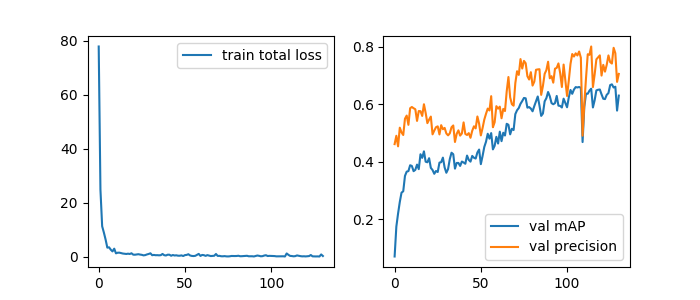

In [8]:
# x = x.tolist()
fig, axes = plt.subplots(ncols=2, figsize=(7, 3))
axes[0].plot([x[k] for k in range(len(x))], label = "train total loss")
axes[0].legend(["train total loss"])
axes[1].plot([y[k] for k in range(len(y))], label = "val mAP")
axes[1].plot([z[k] for k in range(len(y))], label = "val precision")
# axes[1].plot([z[k] for k in range(len(z))], label = "val precision")
axes[1].legend(["val mAP", "val precision"])
# def plot(exp, fig, axes): 
#     axes[0].clear()
#     axes[1].clear()
#     axes[0].plot([x[k] for k in range(len(x))], label = "traning loss")
# #     axes[0].plot([exp.history[kk][1]['loss'] for kk in range(exp.epoch)], label ="evaluate loss")
# #     axes[0].legend(["training loss", "evaluation loss"])
# #     axes[1].plot([exp.history[k][0]['accuracy'] for k in range(exp.epoch)], label = "training accuracy")
# #     axes[1].plot([exp.history[kk][1]['accuracy'] for kk in range(exp.epoch)], label = "evaluate accuracy")
# #     axes[1].legend(["training accuracy", "evaluation accuracy"])
#     plt.tight_layout()
#     fig.canvas.draw()

In [ ]:
[78.57312012 26.66386795 12.40645981  7.78755188  6.11257362  4.05783319
  3.2062006   2.63473129  2.07526636  2.32104468  2.64766026  2.19014668
  1.4358964   1.05858147  1.25316787  1.26524258  0.85739934  1.14031029
  0.93961483  1.13910818]
[0.00766357 0.03678624 0.07740478 0.0913592  0.12956026 0.16808088
 0.19156219 0.24844204 0.26601037 0.27662364 0.26067165 0.28220102
 0.28798825 0.32396507 0.3384288  0.35104926 0.35719529 0.30470759
 0.35488199 0.37594291]
[0.06449358 0.28541341 0.42206774 0.37810908 0.44523386 0.46936261
 0.50203801 0.56042865 0.57681987 0.58831105 0.57576037 0.57207029
 0.62452772 0.62538284 0.62972634 0.63700808 0.62761654 0.5928564
 0.58872465 0.62209737]

In [ ]:
DATASET_YEAR_DICT = {
    '2012': {
        'url': 'http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar',
        'filename': 'VOCtrainval_11-May-2012.tar',
        'md5': '6cd6e144f989b92b3379bac3b3de84fd',
        'base_dir': 'VOCdevkit/VOC2012'
    },
    '2011': {
        'url': 'http://host.robots.ox.ac.uk/pascal/VOC/voc2011/VOCtrainval_25-May-2011.tar',
        'filename': 'VOCtrainval_25-May-2011.tar',
        'md5': '6c3384ef61512963050cb5d687e5bf1e',
        'base_dir': 'TrainVal/VOCdevkit/VOC2011'
    },
    '2010': {
        'url': 'http://host.robots.ox.ac.uk/pascal/VOC/voc2010/VOCtrainval_03-May-2010.tar',
        'filename': 'VOCtrainval_03-May-2010.tar',
        'md5': 'da459979d0c395079b5c75ee67908abb',
        'base_dir': 'VOCdevkit/VOC2010'
    },
    '2009': {
        'url': 'http://host.robots.ox.ac.uk/pascal/VOC/voc2009/VOCtrainval_11-May-2009.tar',
        'filename': 'VOCtrainval_11-May-2009.tar',
        'md5': '59065e4b188729180974ef6572f6a212',
        'base_dir': 'VOCdevkit/VOC2009'
    },
    '2008': {
        'url': 'http://host.robots.ox.ac.uk/pascal/VOC/voc2008/VOCtrainval_14-Jul-2008.tar',
        'filename': 'VOCtrainval_11-May-2012.tar',
        'md5': '2629fa636546599198acfcfbfcf1904a',
        'base_dir': 'VOCdevkit/VOC2008'
    },
    '2007': {
        'url': 'http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar',
        'filename': 'VOCtrainval_06-Nov-2007.tar',
        'md5': 'c52e279531787c972589f7e41ab4ae64',
        'base_dir': 'VOCdevkit/VOC2007'
    }
    
}



In [ ]:
class MarineDetection(data.Dataset):
    """`Pascal VOC <http://host.robots.ox.ac.uk/pascal/VOC/>`_ Detection Dataset.

    Args:
        root (string): Root directory of the VOC Dataset.
        year (string, optional): The dataset year, supports years 2007 to 2012.
        image_set (string, optional): Select the image_set to use, ``train``, ``trainval`` or ``val``
        download (bool, optional): If true, downloads the dataset from the internet and
            puts it in root directory. If dataset is already downloaded, it is not
            downloaded again.
            (default: alphabetic indexing of VOC's 20 classes).
        transform (callable, optional): A function/transform that  takes in an PIL image
            and returns a transformed version. E.g, ``transforms.RandomCrop``
        target_transform (callable, required): A function/transform that takes in the
            target and transforms it.
    """

    def __init__(self,
                 root,
                 year='2012',
                 image_set='train',
                 download=False,
                 transform=None,
                 target_transform=None):
        self.root = os.path.expanduser(root)
        self.year = year
        self.url = DATASET_YEAR_DICT[year]['url']
        self.filename = DATASET_YEAR_DICT[year]['filename']
        self.md5 = DATASET_YEAR_DICT[year]['md5']
        self.transform = transform
        self.target_transform = target_transform
        self.image_set = image_set

        base_dir = DATASET_YEAR_DICT[year]['base_dir']
        voc_root = os.path.join(self.root, base_dir)
        image_dir = os.path.join(voc_root, 'JPEGImages')
        annotation_dir = os.path.join(voc_root, 'Annotations')

        if download:
            download_extract(self.url, self.root, self.filename, self.md5)

        if not os.path.isdir(voc_root):
            raise RuntimeError('Dataset not found or corrupted.' +
                               ' You can use download=True to download it')

        splits_dir = os.path.join(voc_root, 'ImageSets/Main')

        split_f = os.path.join(splits_dir, image_set.rstrip('\n') + '.txt')

        if not os.path.exists(split_f):
            raise ValueError(
                'Wrong image_set entered! Please use image_set="train" '
                'or image_set="trainval" or image_set="val" or a valid'
                'image_set from the VOC ImageSets/Main folder.')

        with open(os.path.join(split_f), "r") as f:
            file_names = [x.strip() for x in f.readlines()]

        self.images = [os.path.join(image_dir, x + ".jpg") for x in file_names]
        self.annotations = [os.path.join(annotation_dir, x + ".xml") for x in file_names]
        assert (len(self.images) == len(self.annotations))

    def __getitem__(self, index):
        """
        Args:
            index (int): Index

        Returns:
            tuple: (image, target) where target is a dictionary of the XML tree.
        """
        img = Image.open(self.images[index]).convert('RGB')
        target = self.parse_voc_xml(
            ET.parse(self.annotations[index]).getroot())

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target

    def __len__(self):
        return len(self.images)
    
    